# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks"

# %cd /content/gdrive/My Drive/Colab Notebooks

In [1]:
#Import all the required libraries
import random
import numpy as np
import pandas as pd
import glob
import pathlib, os
from collections import Counter , OrderedDict
import string
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from keras.preprocessing.image import load_img
import PIL
import PIL.Image
import time

# image processing
from skimage import io
from skimage.transform import rescale, resize

import cv2

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
# sklearn
from sklearn.model_selection import train_test_split
np.set_printoptions(precision=4)

from tqdm import tqdm 

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [2]:
#Import the dataset and read the image into a seperate variable

images='archive/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
image_count = len(all_imgs)
print(all_imgs[:3])
print("The total images present in the dataset: {}".format(image_count))


['archive/Images\\1000268201_693b08cb0e.jpg', 'archive/Images\\1001773457_577c3a7d70.jpg', 'archive/Images\\1002674143_1b742ab4b8.jpg']
The total images present in the dataset: 8091


In [3]:
#Import the dataset and read the text file into a seperate variable
text_file = 'archive/captions.txt'
def load_doc(filename):
    #your code here
    text = open(filename, 'r', encoding = 'utf-8').read()
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


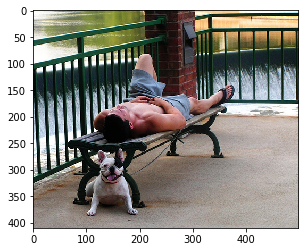

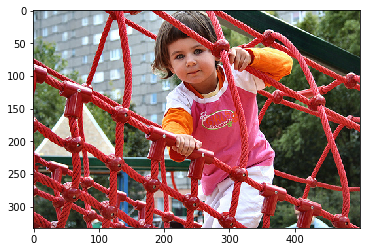

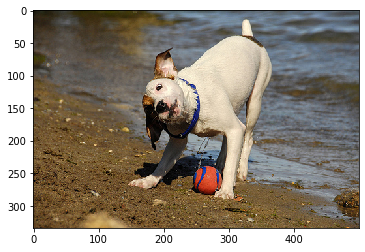

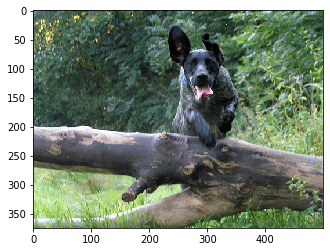

In [4]:
#Visualise both the images & text present in the dataset
for i in range(3, 10, 2):
    plt.figure()
    img = cv2.imread(all_imgs[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [6]:
# utility function to clean the caption text
def clean_caption(caption):
    table = str.maketrans('','', string.punctuation)
    desc = caption.split() #create a list of words

    # remove the punctuation from each word
    desc = [word.translate(table) for word in desc]
    
    # remove empty strings and strings like 's and a
    desc = [word.strip() for word in desc if len(word.strip())>1]
    desc = [word.lower() for word in desc if(word.isalpha())] # convert to lower case and pick only alpha numeric 
    return ' '.join(desc)

In [7]:
# utility token to append <start> and <end>
def appendDelimitingTokes(caption):
    return f'<start> {caption} <end>'

In [8]:
# utility function to generate image path
def getImagePaths(s):
    return s.replace('\\', '/')

In [9]:
def getFileName(path):
    return path[len(images)+1:]

In [10]:
all_img_id= list(map(getFileName, all_imgs))#store all the image id here
all_img_vector= list(map(getImagePaths, all_imgs)) #store all the image path here

In [11]:
# utility function to generate mappings of captions to images as a dictionary with image name as index. 
def MapImageCaptions(doc):
    captionDict = dict()
    text_lines = doc.split('\n')
    # remove the heading line and empty lines
    text_lines = [t for t in text_lines[1:] if len(t)>0]
    for line in text_lines:
        dict_index, dict_val = line.split(',', 1)
        if dict_index not in captionDict:
            captionDict[dict_index] = list()
        captionDict[dict_index].append(dict_val)
    return captionDict

In [12]:
captionMappings = MapImageCaptions(doc)

In [13]:
annotations= captionMappings.values() #store all the captions here

In [14]:
# create a data frame
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
print(df.shape)
df

(8091, 3)


,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,archive/Images/1000268201_693b08cb0e.jpg,[A child in a pink dress is climbing up a set ...
1,1001773457_577c3a7d70.jpg,archive/Images/1001773457_577c3a7d70.jpg,"[A black dog and a spotted dog are fighting, A..."
2,1002674143_1b742ab4b8.jpg,archive/Images/1002674143_1b742ab4b8.jpg,[A little girl covered in paint sits in front ...
3,1003163366_44323f5815.jpg,archive/Images/1003163366_44323f5815.jpg,[A man lays on a bench while his dog sits by h...
4,1007129816_e794419615.jpg,archive/Images/1007129816_e794419615.jpg,[A man in an orange hat starring at something ...
...,...,...,...
8086,990890291_afc72be141.jpg,archive/Images/990890291_afc72be141.jpg,[A man does a wheelie on his bicycle on the si...
8087,99171998_7cc800ceef.jpg,archive/Images/99171998_7cc800ceef.jpg,"[A group is sitting around a snowy crevasse .,..."
8088,99679241_adc853a5c0.jpg,archive/Images/99679241_adc853a5c0.jpg,[A grey bird stands majestically on a beach wh...
8089,997338199_7343367d7f.jpg,archive/Images/997338199_7343367d7f.jpg,"[A person stands near golden walls ., a woman ..."


In [15]:
df = (df
 .set_index(['ID','Path'])['Captions']
 .apply(pd.Series)
 .stack()
 .reset_index()
 .drop('level_2', axis=1)
 .rename(columns={0:'Captions'}))
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,archive/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,archive/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,archive/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,archive/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,archive/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,archive/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,archive/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,archive/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,archive/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [16]:
# reference from  https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html
def image_desc_plotter():
    npic = 5
    npix = 224
    target_size = (npix,npix,3)

    count = 1
    fig = plt.figure(figsize=(10,20))
    for image in all_img_vector[10:15]:
        image_id = getFileName(image)
        captions = list(df["Captions"].loc[df["ID"]==image_id].values)
        image_load = load_img(image, target_size=target_size)

        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

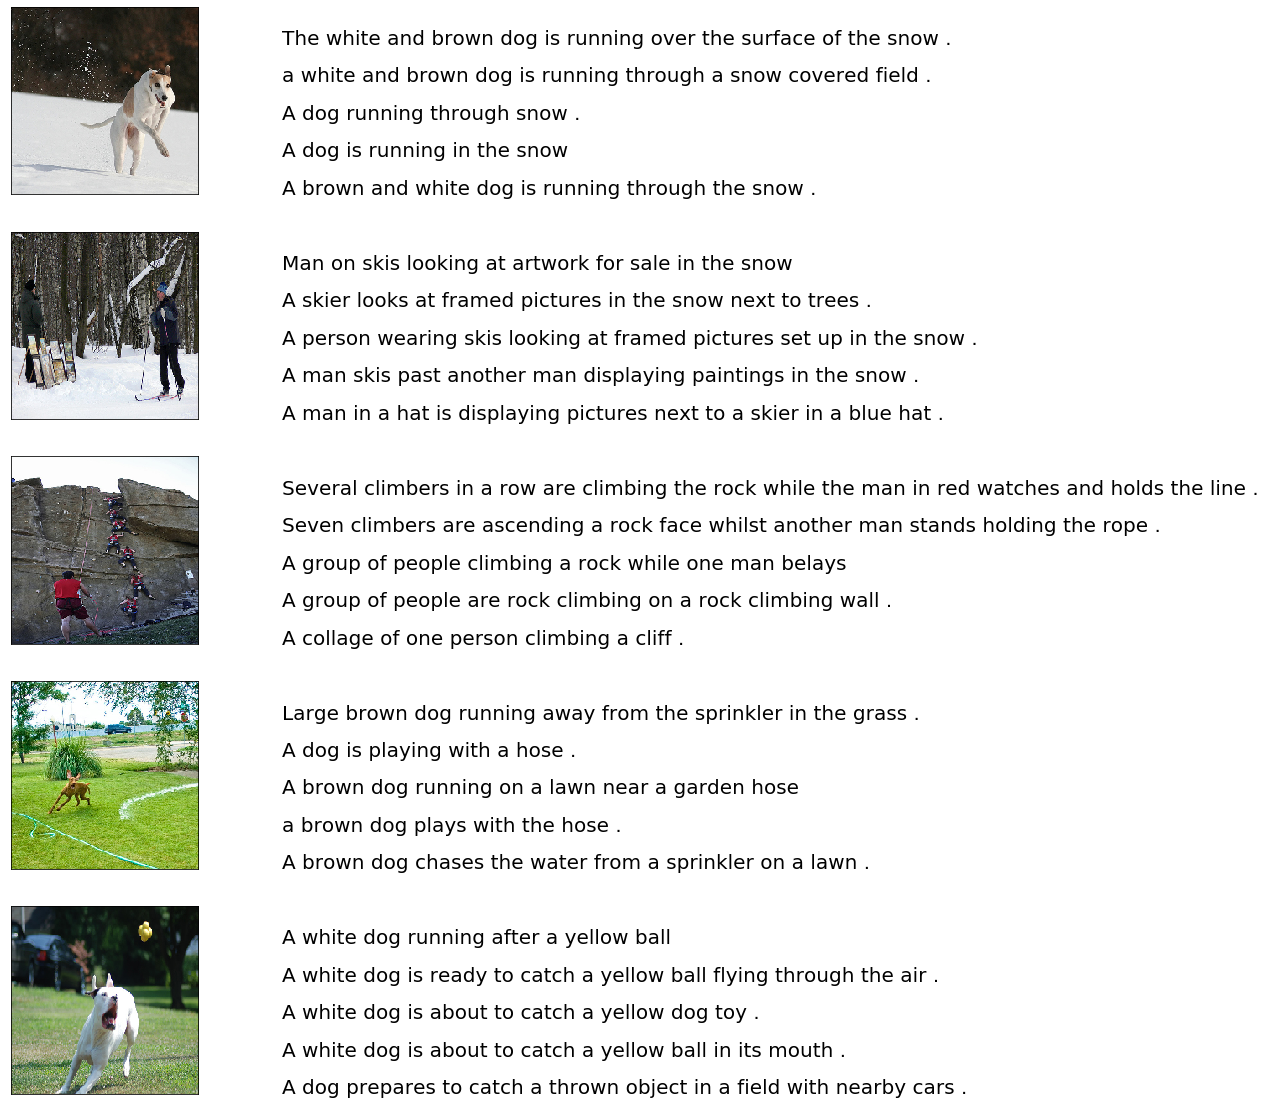

In [17]:
image_desc_plotter()

In [18]:
## returns 2 lists first for clean annotations second for annotations appended with <start> and <end>
def GetAllAnnotations(annotations):
    allcaptions = list()
    dCaptions = list()
    for caption_list in annotations:
        for caption in caption_list:
            caption = clean_caption(caption)
            dCaption = appendDelimitingTokes(caption)
            allcaptions.append(caption)
            dCaptions.append(dCaption)
    return (allcaptions, dCaptions)

In [19]:
#Create a list which contains all the captions
#add the <start> & <end> token to all those captions as well
annotations, delimitedAnnotations = GetAllAnnotations(annotations) #write your code here


#Create a list which contains all the path to the images
all_img_path= all_img_vector#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


In [20]:
annotations[0]

'child in pink dress is climbing up set of stairs in an entry way'

In [21]:
delimitedAnnotations[0]

'<start> child in pink dress is climbing up set of stairs in an entry way <end>'

In [22]:
#Create the vocabulary & the counter for the captions

vocabulary= [word for line in delimitedAnnotations for word in line.split()] #write your code here

val_count=Counter(vocabulary)
# val_count

Counter({'<start>': 40455,
         'child': 1545,
         'in': 18974,
         'pink': 735,
         'dress': 348,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6713,
         'stairs': 109,
         'an': 2432,
         'entry': 1,
         'way': 50,
         '<end>': 40455,
         'girl': 3328,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1768,
         'playhouse': 6,
         'the': 18418,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3832,
         'dog': 8136,
         'and': 8851,
         'spotted': 37,
         'are': 3504,
         'fighting': 132,
         'tricolored': 14,
         'playing': 2008,
         'with': 7765,
         'each': 430,
         'other': 773,
         'on': 10743,
         'road': 388,
         'white': 3940,
         'brown': 2563,
         'spots': 29,
         'staring': 57,
      

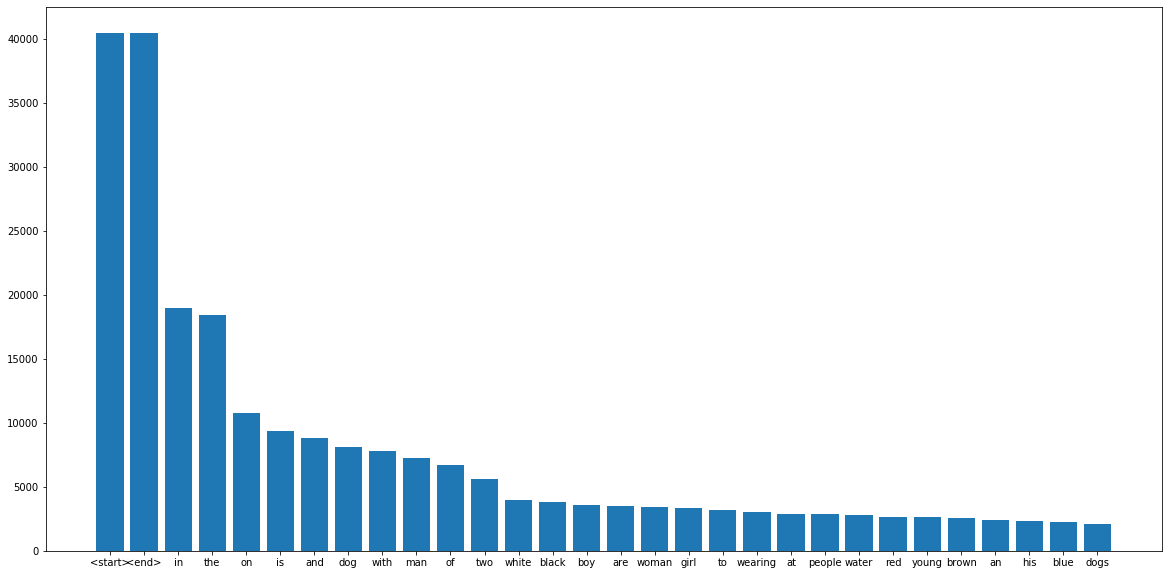

In [23]:
#Visualise the top 30 occuring words in the captions
#write your code here
plt.figure(figsize=(20, 10))
top_words = OrderedDict(val_count.most_common(30))
plt.bar(top_words.keys(), top_words.values())
plt.show()

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [24]:
# create the tokenizer
# create the tokenizer
tokenizer = Tokenizer(num_words = 5001 , oov_token='<unk>')
tokenizer.fit_on_texts(delimitedAnnotations)

In [25]:
# Create word-to-index and index-to-word mappings.
# word to index mapping
wordIndex = tokenizer.word_index

In [26]:
#index-to-word mappings
indexToWord = tokenizer.index_word

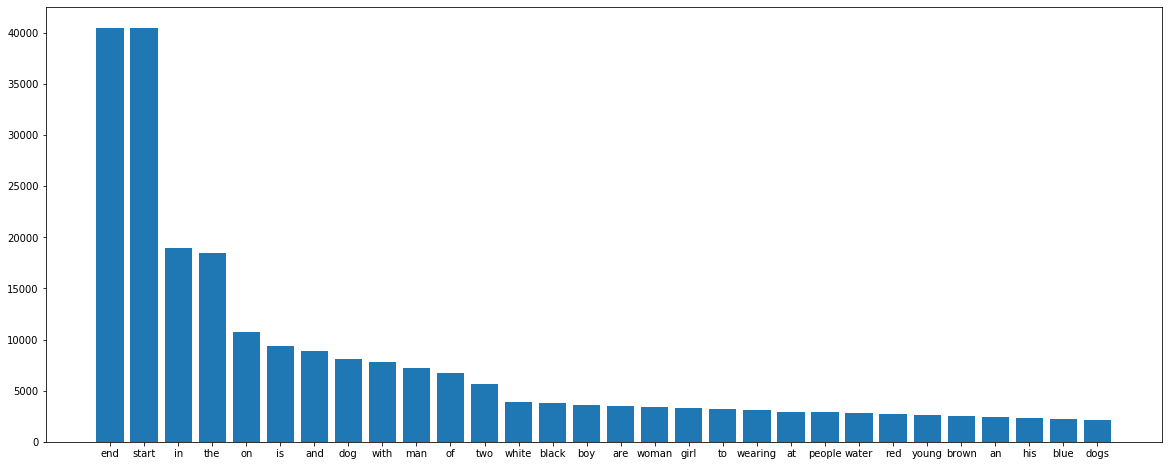

In [27]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
wordCounts = tokenizer.word_counts
plt.figure(figsize=(20, 8))
top_words = OrderedDict(Counter(wordCounts).most_common(30))
plt.bar(top_words.keys(), top_words.values())
plt.show()

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [28]:
text_sequences = tokenizer.texts_to_sequences(delimitedAnnotations)

In [29]:
MaxLength = max(len(d) for d in text_sequences)
MaxLength

34

In [30]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
cap_vector= pad_sequences(text_sequences, maxlen=MaxLength, padding='post') #your code here
print("The shape of Caption vector is :" + str(cap_vector.shape))
cap_vector

The shape of Caption vector is :(40455, 34)


array([[  3,  42,   4, ...,   0,   0,   0],
       [  3,  19, 313, ...,   0,   0,   0],
       [  3,  40,  19, ...,   0,   0,   0],
       ...,
       [  3,  43,   4, ...,   0,   0,   0],
       [  3,  84, 357, ...,   0,   0,   0],
       [  3,  84, 357, ...,   0,   0,   0]])

In [31]:
df['Captions'] = df['Captions'].apply(lambda x:appendDelimitingTokes(clean_caption(x)))

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [32]:
#write your code here
# define the image size
rows = 299
cols = 299

def get_encoded_label(label):
    text_sequences = tokenizer.texts_to_sequences([label])
    return pad_sequences(text_sequences, maxlen=MaxLength, padding='post')[0]

# define a function to resize the images on demand.
def resize_image(image, height=rows, width=cols):
    img = tf.image.decode_jpeg(image, channels=3)
    # resize the image to the desired size
    img = tf.image.resize(img, [height, width])
    return tf.keras.applications.inception_v3.preprocess_input(img)

# define a function to normalize the images on demand between -1 and 1
def normalize_image(image):
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
    return normalization_layer(image)
    
# utility function to read image from given path and process it for inception model
def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, file_path

# function to load feature vector saved using imagenet earlier and map it to caption
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

'archive/Images/1000268201_693b08cb0e.jpg'

In [57]:
map_func(b'archive/Images/1000268201_693b08cb0e.jpg', 'caption')

(array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.1699],
        [0.    , 0.    , 1.0107, ..., 0.    , 0.    , 0.0611],
        ...,
        [0.    , 0.    , 2.038 , ..., 1.2027, 0.    , 1.9924],
        [0.    , 0.    , 0.9046, ..., 0.    , 0.    , 0.    ],
        [0.    , 1.2526, 0.    , ..., 0.    , 0.    , 0.    ]],
       dtype=float32),
 'caption')

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [33]:
# get data from dataframe based on keys
def getKeyValueLists(keys):
    data = df.loc[df['ID'].isin(keys)]
    return data['Path'].tolist(), data['Captions'].tolist()

In [34]:
train_images, val_images = train_test_split(all_img_id, train_size=0.8, random_state = 42)
len(train_images),len(val_images)

(6472, 1619)

In [35]:
train_image_idx, train_captions = getKeyValueLists(train_images)
print(len(train_image_idx), len(train_captions))

32360 32360


In [36]:
val_image_idx, val_captions = getKeyValueLists(val_images)
print(len(val_image_idx), len(val_captions))

8095 8095


In [37]:
batch_size=30
BUFFER_SIZE = 1000

In [38]:
image_vector = sorted(set(all_img_vector))

In [39]:
image_dataset = tf.data.Dataset.from_tensor_slices(image_vector)

In [40]:
image_dataset = image_dataset.map(
  process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)

In [41]:
i = 0
for element in image_dataset.as_numpy_iterator():
    print(element[0].shape, element[1].shape)
    i = i+1
    if i>3:
        break

(30, 299, 299, 3) (30,)
(30, 299, 299, 3) (30,)
(30, 299, 299, 3) (30,)
(30, 299, 299, 3) (30,)


In [42]:
train_dataset = image_dataset.shuffle(BUFFER_SIZE).batch(batch_size)

In [43]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(30, 299, 299, 3)
(30,)


In [ ]:
a

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [44]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input  #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model =  tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [63]:
# write your code to extract features from each image in the dataset
i = 0
for img, path in image_dataset:
    print(path.numpy())
    try:
        img_tensor = np.load(path[0].numpy().decode('utf-8')+'.npy')
    except (IOError, FileNotFoundError) as exp:
        batch_features = image_features_extract_model(img)
        batch_features = tf.reshape(batch_features,
                                  (batch_features.shape[0], -1, batch_features.shape[3]))

        # we save the features to disk. 
        for bf, p in zip(batch_features, path):
            path_of_feature = p.numpy().decode("utf-8")
            np.save(path_of_feature, bf.numpy())
#     i=i+1
#     if i>0:
#         break

[b'archive/Images/1000268201_693b08cb0e.jpg'
 b'archive/Images/1001773457_577c3a7d70.jpg'
 b'archive/Images/1002674143_1b742ab4b8.jpg'
 b'archive/Images/1003163366_44323f5815.jpg'
 b'archive/Images/1007129816_e794419615.jpg'
 b'archive/Images/1007320043_627395c3d8.jpg'
 b'archive/Images/1009434119_febe49276a.jpg'
 b'archive/Images/1012212859_01547e3f17.jpg'
 b'archive/Images/1015118661_980735411b.jpg'
 b'archive/Images/1015584366_dfcec3c85a.jpg'
 b'archive/Images/101654506_8eb26cfb60.jpg'
 b'archive/Images/101669240_b2d3e7f17b.jpg'
 b'archive/Images/1016887272_03199f49c4.jpg'
 b'archive/Images/1019077836_6fc9b15408.jpg'
 b'archive/Images/1019604187_d087bf9a5f.jpg'
 b'archive/Images/1020651753_06077ec457.jpg'
 b'archive/Images/1022454332_6af2c1449a.jpg'
 b'archive/Images/1022454428_b6b660a67b.jpg'
 b'archive/Images/1022975728_75515238d8.jpg'
 b'archive/Images/102351840_323e3de834.jpg'
 b'archive/Images/1024138940_f1fefbdce1.jpg'
 b'archive/Images/102455176_5f8ead62d5.jpg'
 b'archive/Ima

[b'archive/Images/1303727066_23d0f6ed43.jpg'
 b'archive/Images/1303727828_d1052ee341.jpg'
 b'archive/Images/1304100320_c8990a1539.jpg'
 b'archive/Images/1304961697_76b86b0c18.jpg'
 b'archive/Images/1305564994_00513f9a5b.jpg'
 b'archive/Images/1306145560_1e37081b91.jpg'
 b'archive/Images/1307635496_94442dc21a.jpg'
 b'archive/Images/1308472581_9961782889.jpg'
 b'archive/Images/1308617539_54e1a3dfbe.jpg'
 b'archive/Images/1309330801_aeeb23f1ee.jpg'
 b'archive/Images/1311132744_5ffd03f831.jpg'
 b'archive/Images/1311388430_4ab0cd1a1f.jpg'
 b'archive/Images/1312020846_5abb4a9be2.jpg'
 b'archive/Images/1312227131_771b5ed201.jpg'
 b'archive/Images/1312954382_cf6d70d63a.jpg'
 b'archive/Images/1313693129_71d0b21c63.jpg'
 b'archive/Images/1313961775_824b87d155.jpg'
 b'archive/Images/1316247213_1d2c726dd5.jpg'
 b'archive/Images/131632409_4de0d4e710.jpg'
 b'archive/Images/1317292658_ba29330a0b.jpg'
 b'archive/Images/1319634306_816f21677f.jpg'
 b'archive/Images/1321723162_9d4c78b8af.jpg'
 b'archive/

[b'archive/Images/1468429623_f001988691.jpg'
 b'archive/Images/1468962616_5803b4397f.jpg'
 b'archive/Images/1469000260_5d473c8283.jpg'
 b'archive/Images/1469358746_2a879abaf3.jpg'
 b'archive/Images/1470061031_4cb59c12a8.jpg'
 b'archive/Images/1470132731_fa416b7504.jpg'
 b'archive/Images/1470536919_1f3fd6c65a.jpg'
 b'archive/Images/1472053993_bed67a3ba7.jpg'
 b'archive/Images/1472230829_803818a383.jpg'
 b'archive/Images/1472249944_d887c3aeda.jpg'
 b'archive/Images/1472653060_7427d2865a.jpg'
 b'archive/Images/1472882567_33dc14c8b6.jpg'
 b'archive/Images/1473080948_bae2925dc8.jpg'
 b'archive/Images/1473250020_dc829a090f.jpg'
 b'archive/Images/1473618073_7db56a5237.jpg'
 b'archive/Images/1474474514_b3eb492722.jpg'
 b'archive/Images/1475046848_831245fc64.jpg'
 b'archive/Images/1476002408_4256b7b2fa.jpg'
 b'archive/Images/1476241331_2f43b67aed.jpg'
 b'archive/Images/1478268555_7e301fc510.jpg'
 b'archive/Images/1478294229_7e1c822fea.jpg'
 b'archive/Images/1478606153_a7163bf899.jpg'
 b'archive

 b'archive/Images/191003284_1025b0fb7d.jpg']
[b'archive/Images/191003285_edd8d0cf58.jpg'
 b'archive/Images/191003287_2915c11d8e.jpg'
 b'archive/Images/191592626_477ef5e026.jpg'
 b'archive/Images/1917203130_fcaff8b10e.jpg'
 b'archive/Images/1917265421_aeccf1ca38.jpg'
 b'archive/Images/1918573100_d31cbb6b77.jpg'
 b'archive/Images/19212715_20476497a3.jpg'
 b'archive/Images/1921398767_771743bf4e.jpg'
 b'archive/Images/1923476156_e20976b32d.jpg'
 b'archive/Images/1924234308_c9ddcf206d.jpg'
 b'archive/Images/1925434818_2949a8f6d8.jpg'
 b'archive/Images/1926129518_4350f4f552.jpg'
 b'archive/Images/1928319708_ccf1f4ee72.jpg'
 b'archive/Images/1931690777_897a7d8ab6.jpg'
 b'archive/Images/1932161768_996eadac87.jpg'
 b'archive/Images/1932314876_9cc46fd054.jpg'
 b'archive/Images/1936215201_d03a75cbba.jpg'
 b'archive/Images/1937104503_313d22a2d0.jpg'
 b'archive/Images/1937262236_cbf5bfa101.jpg'
 b'archive/Images/1947351225_288d788983.jpg'
 b'archive/Images/195084264_72fb347b0f.jpg'
 b'archive/Image

 b'archive/Images/2095444126_201ff9f222.jpg']
[b'archive/Images/2095478050_736c4d2d28.jpg'
 b'archive/Images/209605542_ca9cc52e7b.jpg'
 b'archive/Images/2096771662_984441d20d.jpg'
 b'archive/Images/2097398349_ff178b3f1b.jpg'
 b'archive/Images/2097403787_77a154f5b9.jpg'
 b'archive/Images/2097407245_c798e0dcaf.jpg'
 b'archive/Images/2097420505_439f63c863.jpg'
 b'archive/Images/2097489021_ca1b9f5c3b.jpg'
 b'archive/Images/2098174172_e57d86ea03.jpg'
 b'archive/Images/2098418613_85a0c9afea.jpg'
 b'archive/Images/2098646162_e3b3bbf14c.jpg'
 b'archive/Images/2099323664_bb20457f26.jpg'
 b'archive/Images/2100046085_69b59b6645.jpg'
 b'archive/Images/2100735137_05c6079537.jpg'
 b'archive/Images/2100816230_ff866fb352.jpg'
 b'archive/Images/2100909581_b7dde5b704.jpg'
 b'archive/Images/2101128963_fdf8b2a0d7.jpg'
 b'archive/Images/210126070_0d43b300b9.jpg'
 b'archive/Images/2101457132_69c950bc45.jpg'
 b'archive/Images/2101808682_0d66ef4a08.jpg'
 b'archive/Images/2102030040_2e8f4738f7.jpg'
 b'archive/

 b'archive/Images/2209496328_2a34fd201d.jpg']
[b'archive/Images/2209888959_d636b1be0b.jpg'
 b'archive/Images/2210368267_0615754b48.jpg'
 b'archive/Images/2211593099_4a4f1c85d2.jpg'
 b'archive/Images/2212472643_80238475b5.jpg'
 b'archive/Images/2213113526_beeb4f9bdc.jpg'
 b'archive/Images/2214132302_80064fd79d.jpg'
 b'archive/Images/2214847438_4993210d4c.jpg'
 b'archive/Images/2215136723_960edfea49.jpg'
 b'archive/Images/2215165918_2bf5b659dd.jpg'
 b'archive/Images/2216568822_84c295c3b0.jpg'
 b'archive/Images/2216695423_1362cb25f3.jpg'
 b'archive/Images/2217328285_b1d55c17ca.jpg'
 b'archive/Images/2217728745_92b6779016.jpg'
 b'archive/Images/2218334049_e649dbdb1a.jpg'
 b'archive/Images/2218519240_cac5aab53c.jpg'
 b'archive/Images/2218609886_892dcd6915.jpg'
 b'archive/Images/2218743570_9d6614c51c.jpg'
 b'archive/Images/2218843713_cf28ea319e.jpg'
 b'archive/Images/2218907190_5f43bf5e4d.jpg'
 b'archive/Images/221973402_ecb1cd51f1.jpg'
 b'archive/Images/2219805467_370ee1b7aa.jpg'
 b'archive

[b'archive/Images/2308256827_3c0a7d514d.jpg'
 b'archive/Images/2308271254_27fb466eb4.jpg'
 b'archive/Images/2308978137_bfe776d541.jpg'
 b'archive/Images/2309327462_82a24538d4.jpg'
 b'archive/Images/2309860995_c2e2a0feeb.jpg'
 b'archive/Images/2310108346_e82d209ccd.jpg'
 b'archive/Images/2310126952_7dc86d88f6.jpg'
 b'archive/Images/2310233145_910cb5b4c8.jpg'
 b'archive/Images/2311690895_0d6efe11c8.jpg'
 b'archive/Images/2312731013_1a3a8e25c6.jpg'
 b'archive/Images/2312746782_4528a5b818.jpg'
 b'archive/Images/2312747482_20a81b2230.jpg'
 b'archive/Images/2312984882_bec7849e09.jpg'
 b'archive/Images/2313230479_13f87c6bf3.jpg'
 b'archive/Images/2313822078_282dc07531.jpg'
 b'archive/Images/2314722788_6262c3aa40.jpg'
 b'archive/Images/2314732154_83bc7f7314.jpg'
 b'archive/Images/2315418282_80bd0bb1c0.jpg'
 b'archive/Images/2315807231_6948b3f3a5.jpg'
 b'archive/Images/2315867011_fc5fc9fa6d.jpg'
 b'archive/Images/2316097768_ef662f444b.jpg'
 b'archive/Images/2317714088_bcd081f926.jpg'
 b'archive

[b'archive/Images/2394763838_99d1435b85.jpg'
 b'archive/Images/2394824046_51cec8e5e7.jpg'
 b'archive/Images/2394857899_76bfdf720b.jpg'
 b'archive/Images/2394919002_ed7527ff93.jpg'
 b'archive/Images/2394922193_310166d6af.jpg'
 b'archive/Images/2395967330_7e6ea404f6.jpg'
 b'archive/Images/2396025708_e4a72e2558.jpg'
 b'archive/Images/2396100671_3a9d67f03d.jpg'
 b'archive/Images/2396669903_5217a83641.jpg'
 b'archive/Images/2396691909_6b8c2f7c44.jpg'
 b'archive/Images/2396746868_0727e06983.jpg'
 b'archive/Images/239807547_4923efc821.jpg'
 b'archive/Images/2398605966_1d0c9e6a20.jpg'
 b'archive/Images/2399114095_c3196ff456.jpg'
 b'archive/Images/2399219552_bbba0a9a59.jpg'
 b'archive/Images/2399551242_c62a46dd5f.jpg'
 b'archive/Images/2400958566_4e09424046.jpg'
 b'archive/Images/2402462857_7684848704.jpg'
 b'archive/Images/2402744031_11f9f2f2b8.jpg'
 b'archive/Images/2402793046_3385554e81.jpg'
 b'archive/Images/2403078014_4b1d6f8bde.jpg'
 b'archive/Images/2403376030_903521c371.jpg'
 b'archive/

 b'archive/Images/2465218087_fca77998c6.jpg']
[b'archive/Images/2465441099_a1761a1757.jpg'
 b'archive/Images/2465497494_43d74df57c.jpg'
 b'archive/Images/2465691083_894fc48af6.jpg'
 b'archive/Images/2466093839_33bbc8cbd9.jpg'
 b'archive/Images/2466171100_5e60cfcc11.jpg'
 b'archive/Images/2466171114_3fa51415a7.jpg'
 b'archive/Images/2466420387_86fe77c966.jpg'
 b'archive/Images/2466495935_623b144183.jpg'
 b'archive/Images/2467803152_70eeca1334.jpg'
 b'archive/Images/2467821766_0510c9a2d1.jpg'
 b'archive/Images/2467850190_07a74d89b7.jpg'
 b'archive/Images/2467853482_17009933e8.jpg'
 b'archive/Images/2467856402_0490413d38.jpg'
 b'archive/Images/246901891_4c4ea49c3a.jpg'
 b'archive/Images/2469351714_d72becd21e.jpg'
 b'archive/Images/2469498117_b4543e1460.jpg'
 b'archive/Images/2469620360_6c620c6f35.jpg'
 b'archive/Images/2470486377_c3a39ccb7b.jpg'
 b'archive/Images/2470493181_2efbbf17bd.jpg'
 b'archive/Images/2470519275_65725fd38d.jpg'
 b'archive/Images/2470588201_955132a946.jpg'
 b'archive

[b'archive/Images/2533642917_a5eace85e6.jpg'
 b'archive/Images/2534194182_ac53035cf4.jpg'
 b'archive/Images/2534424894_ccd091fcb5.jpg'
 b'archive/Images/2534502836_7a75305655.jpg'
 b'archive/Images/2534652796_c8a23288ab.jpg'
 b'archive/Images/2535746605_8124bf4e4f.jpg'
 b'archive/Images/2537119659_fa01dd5de5.jpg'
 b'archive/Images/2537197415_af7c30dfc8.jpg'
 b'archive/Images/2537583012_4a358a6a8a.jpg'
 b'archive/Images/253762507_9c3356c2f6.jpg'
 b'archive/Images/2538423833_d1f492d1fb.jpg'
 b'archive/Images/2538477523_1da77eb11c.jpg'
 b'archive/Images/2539933563_17ff0758c7.jpg'
 b'archive/Images/2540203582_9a9ac92a5d.jpg'
 b'archive/Images/2540326842_bb26cec999.jpg'
 b'archive/Images/2540360421_f7c2401da8.jpg'
 b'archive/Images/2540750172_070250ece5.jpg'
 b'archive/Images/2540751930_d71c7f5622.jpg'
 b'archive/Images/2540757246_5a849fbdcb.jpg'
 b'archive/Images/2540884723_03d60ef548.jpg'
 b'archive/Images/2541104331_a2d65cfa54.jpg'
 b'archive/Images/2541701582_0a651c380f.jpg'
 b'archive/

[b'archive/Images/2602415701_7674eb19e4.jpg'
 b'archive/Images/2602679255_785b851b46.jpg'
 b'archive/Images/2602866141_be9928408d.jpg'
 b'archive/Images/2603033456_3584d95116.jpg'
 b'archive/Images/2603125422_659391f961.jpg'
 b'archive/Images/2603334363_cfa32c4482.jpg'
 b'archive/Images/2603690144_7a28b1d13c.jpg'
 b'archive/Images/2603792708_18a97bac97.jpg'
 b'archive/Images/260392825_ea61660633.jpg'
 b'archive/Images/2604305843_ebe3e8a328.jpg'
 b'archive/Images/2604825598_593a825b5b.jpg'
 b'archive/Images/260520547_944f9f4c91.jpg'
 b'archive/Images/2606433181_f8f9d38579.jpg'
 b'archive/Images/2607099736_8681f601d9.jpg'
 b'archive/Images/2607130765_97833d6ce1.jpg'
 b'archive/Images/2607383384_d9ce9de793.jpg'
 b'archive/Images/2607462776_78e639d891.jpg'
 b'archive/Images/260828892_7925d27865.jpg'
 b'archive/Images/2608289957_044849f73e.jpg'
 b'archive/Images/260850192_fd03ea26f1.jpg'
 b'archive/Images/2609836649_b55831ed41.jpg'
 b'archive/Images/2609847254_0ec40c1cce.jpg'
 b'archive/Ima

 b'archive/Images/2684323357_c7a6d05d05.jpg']
[b'archive/Images/2684489465_32ba1d0344.jpg'
 b'archive/Images/2685139184_4ff45e0f76.jpg'
 b'archive/Images/2685752892_9d5cd7f274.jpg'
 b'archive/Images/2685788323_ceab14534a.jpg'
 b'archive/Images/2686432878_0697dbc048.jpg'
 b'archive/Images/268654674_d29e00b3d0.jpg'
 b'archive/Images/268704620_8a8cef4cb3.jpg'
 b'archive/Images/2687229880_97cfd8148e.jpg'
 b'archive/Images/2687328779_b4356dab16.jpg'
 b'archive/Images/2687529141_edee32649e.jpg'
 b'archive/Images/2687539673_d54a8dc613.jpg'
 b'archive/Images/2687672606_275169c35d.jpg'
 b'archive/Images/2688102742_885e578a3f.jpg'
 b'archive/Images/2688902319_52ceaf4a2a.jpg'
 b'archive/Images/2689001252_e0016c89f0.jpg'
 b'archive/Images/2689163361_4939875be5.jpg'
 b'archive/Images/2689358407_9932f1b20c.jpg'
 b'archive/Images/2689491604_d8760f57b4.jpg'
 b'archive/Images/2690538407_7ca157be85.jpg'
 b'archive/Images/2690702549_cf81da8cf6.jpg'
 b'archive/Images/2691966747_cfa154982b.jpg'
 b'archive/

 b'archive/Images/276356412_dfa01c3c9e.jpg']
[b'archive/Images/2763601657_09a52a063f.jpg'
 b'archive/Images/2764178773_d63b502812.jpg'
 b'archive/Images/2764732789_1392e962d0.jpg'
 b'archive/Images/2765029348_667111fc30.jpg'
 b'archive/Images/2765747519_2b851e01d6.jpg'
 b'archive/Images/2766148353_70b2e8070f.jpg'
 b'archive/Images/2766291711_4e13a2b594.jpg'
 b'archive/Images/2766325714_189bbff388.jpg'
 b'archive/Images/2766630484_ce73f47031.jpg'
 b'archive/Images/2766726291_b83eb5d315.jpg'
 b'archive/Images/2766765386_4c0beb939d.jpg'
 b'archive/Images/2766854400_640e2abe08.jpg'
 b'archive/Images/2766926202_4201bf2bf9.jpg'
 b'archive/Images/276699720_fe6718fd03.jpg'
 b'archive/Images/2768021570_46bc6325e3.jpg'
 b'archive/Images/2768248810_06d543c080.jpg'
 b'archive/Images/2768662025_44001fe5d1.jpg'
 b'archive/Images/2768972186_92787cd523.jpg'
 b'archive/Images/2769605231_dae8b30201.jpg'
 b'archive/Images/2769731772_18c44c18e2.jpg'
 b'archive/Images/2771424045_1fdf9617eb.jpg'
 b'archive/

[b'archive/Images/2854291706_d4c31dbf56.jpg'
 b'archive/Images/2854959952_3991a385ab.jpg'
 b'archive/Images/2855417531_521bf47b50.jpg'
 b'archive/Images/2855594918_1d1e6a6061.jpg'
 b'archive/Images/2855667597_bf6ceaef8e.jpg'
 b'archive/Images/2855695119_4342aae0a3.jpg'
 b'archive/Images/2855727603_e917ded363.jpg'
 b'archive/Images/285586547_c81f8905a1.jpg'
 b'archive/Images/2855910826_d075845288.jpg'
 b'archive/Images/2856080862_95d793fa9d.jpg'
 b'archive/Images/2856252334_1b1a230e70.jpg'
 b'archive/Images/2856456013_335297f587.jpg'
 b'archive/Images/2856524322_1d04452a21.jpg'
 b'archive/Images/2856699493_65edef80a1.jpg'
 b'archive/Images/2856700531_312528eea4.jpg'
 b'archive/Images/2856923934_6eb8832c9a.jpg'
 b'archive/Images/2857372127_d86639002c.jpg'
 b'archive/Images/2857473929_4f52662c30.jpg'
 b'archive/Images/2857558098_98e9249284.jpg'
 b'archive/Images/2857609295_16aaa85293.jpg'
 b'archive/Images/2858439751_daa3a30ab8.jpg'
 b'archive/Images/2858759108_6e697c5f3e.jpg'
 b'archive/

[b'archive/Images/2913207978_9e9624e249.jpg'
 b'archive/Images/2913818905_8e4d9aa82a.jpg'
 b'archive/Images/2913965136_2d00136697.jpg'
 b'archive/Images/2913972180_547783dd3d.jpg'
 b'archive/Images/2914206497_5e36ac6324.jpg'
 b'archive/Images/2914331767_8574e7703d.jpg'
 b'archive/Images/2914737181_0c8e052da8.jpg'
 b'archive/Images/2914800692_0c512d27b8.jpg'
 b'archive/Images/2915183095_4ed4aa4f37.jpg'
 b'archive/Images/2915538325_59e11276dd.jpg'
 b'archive/Images/2916009941_34a0013803.jpg'
 b'archive/Images/2916586390_664f0139ea.jpg'
 b'archive/Images/2917057791_3d68a055ca.jpg'
 b'archive/Images/2917843040_7c9caaaa8a.jpg'
 b'archive/Images/2918653119_f535fc25c4.jpg'
 b'archive/Images/2918769188_565dd48060.jpg'
 b'archive/Images/2918880895_e61f74f2f0.jpg'
 b'archive/Images/2919459517_b8b858afa3.jpg'
 b'archive/Images/291952021_f111b0fb3d.jpg'
 b'archive/Images/2920305300_a5b1b2329a.jpg'
 b'archive/Images/2920516901_23d8571419.jpg'
 b'archive/Images/2920969723_83918fe909.jpg'
 b'archive/

[b'archive/Images/2987328689_96a2d814f1.jpg'
 b'archive/Images/2987576188_f82304f394.jpg'
 b'archive/Images/2987775031_3f9ac69319.jpg'
 b'archive/Images/2988244398_5da7012fce.jpg'
 b'archive/Images/2988439935_7cea05bc48.jpg'
 b'archive/Images/298920219_9a3f80acc5.jpg'
 b'archive/Images/2990471798_73c50c76fb.jpg'
 b'archive/Images/2990563425_2f7246f458.jpg'
 b'archive/Images/2990977776_1ec51c9281.jpg'
 b'archive/Images/2991375936_bf4b0a7dc0.jpg'
 b'archive/Images/2991575785_bd4868e215.jpg'
 b'archive/Images/2991771557_d98fa0a69f.jpg'
 b'archive/Images/299178969_5ca1de8e40.jpg'
 b'archive/Images/299181827_8dc714101b.jpg'
 b'archive/Images/2991993027_36ac04e9a0.jpg'
 b'archive/Images/2991994415_504d1c0a03.jpg'
 b'archive/Images/2991994607_06f24ec7a6.jpg'
 b'archive/Images/2992614450_b5a6692239.jpg'
 b'archive/Images/2992658871_ac786d37a6.jpg'
 b'archive/Images/2992808092_5f677085b7.jpg'
 b'archive/Images/2992999413_018f48aabc.jpg'
 b'archive/Images/2993049054_611f900644.jpg'
 b'archive/Im

 b'archive/Images/3058627443_1d57ff0a2c.jpg']
[b'archive/Images/3060519665_4d6b9a51b2.jpg'
 b'archive/Images/3060594966_030658d318.jpg'
 b'archive/Images/3060969260_08f43e4f4f.jpg'
 b'archive/Images/3061481868_d1e00b1f2e.jpg'
 b'archive/Images/3062173277_bfb5ef4c45.jpg'
 b'archive/Images/3062273350_fd66106f21.jpg'
 b'archive/Images/306315650_e064f5c677.jpg'
 b'archive/Images/306318683_5f1f875191.jpg'
 b'archive/Images/3063544435_10516c6937.jpg'
 b'archive/Images/3064097919_e536ab9693.jpg'
 b'archive/Images/3064383768_f6838f57da.jpg'
 b'archive/Images/3064716525_b8418d4946.jpg'
 b'archive/Images/3065468339_4955e90fd3.jpg'
 b'archive/Images/3065560742_f6e266ccd9.jpg'
 b'archive/Images/3066338314_2c3fb731d1.jpg'
 b'archive/Images/3066429707_842e50b8f7.jpg'
 b'archive/Images/3066491113_86569e15be.jpg'
 b'archive/Images/3067500667_0fce8f28d4.jpg'
 b'archive/Images/3067885047_f69d90c35b.jpg'
 b'archive/Images/3067971348_69af5bb309.jpg'
 b'archive/Images/3068407619_5207b26986.jpg'
 b'archive/

 b'archive/Images/3119903318_d032141839.jpg']
[b'archive/Images/3119913014_688d4997d7.jpg'
 b'archive/Images/3120189281_1938460e85.jpg'
 b'archive/Images/3120266797_47e7d91614.jpg'
 b'archive/Images/3120648767_812c72eabe.jpg'
 b'archive/Images/3120953244_b00b152246.jpg'
 b'archive/Images/3121482932_f77ca12c01.jpg'
 b'archive/Images/3121521593_18f0ec14f7.jpg'
 b'archive/Images/312156254_ef31dca5ed.jpg'
 b'archive/Images/3122497129_d08f5729b8.jpg'
 b'archive/Images/3122579598_14841c038a.jpg'
 b'archive/Images/3122606953_a979dd3d33.jpg'
 b'archive/Images/3122773470_b622205948.jpg'
 b'archive/Images/3122888809_9ae9b4b9b2.jpg'
 b'archive/Images/3122938209_2b2c6c1fab.jpg'
 b'archive/Images/3123351642_3794f2f601.jpg'
 b'archive/Images/3123463486_f5b36a3624.jpg'
 b'archive/Images/3123526484_02952e40fc.jpg'
 b'archive/Images/3123770450_cedc16d162.jpg'
 b'archive/Images/312427606_defa0dfaa8.jpg'
 b'archive/Images/3124549928_10904a5a83.jpg'
 b'archive/Images/3124838157_7ef96745b7.jpg'
 b'archive/

[b'archive/Images/3175446111_681a89f873.jpg'
 b'archive/Images/3175712926_5a470d0886.jpg'
 b'archive/Images/3175849727_bf30b892cb.jpg'
 b'archive/Images/3176072448_b84c99cf7f.jpg'
 b'archive/Images/3176131893_7181c733aa.jpg'
 b'archive/Images/3176277818_235486a3cd.jpg'
 b'archive/Images/3176278670_195eea071c.jpg'
 b'archive/Images/317641829_ab2607a6c0.jpg'
 b'archive/Images/3176498130_52ab9460b2.jpg'
 b'archive/Images/3176968956_d942a93513.jpg'
 b'archive/Images/3177298173_78cea31d64.jpg'
 b'archive/Images/3177468217_56a9142e46.jpg'
 b'archive/Images/3177799416_5bd0382370.jpg'
 b'archive/Images/3178005751_fca19815ac.jpg'
 b'archive/Images/3178300150_d4605ff02c.jpg'
 b'archive/Images/3178371973_60c6b8f110.jpg'
 b'archive/Images/3178489390_13a6ae7524.jpg'
 b'archive/Images/3178599352_c57fdebcd2.jpg'
 b'archive/Images/3179336562_c3d0c0a3bd.jpg'
 b'archive/Images/3179952488_c1c812a03b.jpg'
 b'archive/Images/318070878_92ead85868.jpg'
 b'archive/Images/3180806542_49b6de312d.jpg'
 b'archive/I

[b'archive/Images/3224227640_31865b3651.jpg'
 b'archive/Images/3224560800_8fefd52510.jpg'
 b'archive/Images/3224578187_749882c17f.jpg'
 b'archive/Images/3224904543_679fe05c41.jpg'
 b'archive/Images/3225025519_c089c14559.jpg'
 b'archive/Images/3225037367_a71fa86319.jpg'
 b'archive/Images/3225058391_a12d38d911.jpg'
 b'archive/Images/3225226381_9fe306fb9e.jpg'
 b'archive/Images/3225296260_2ee72b4917.jpg'
 b'archive/Images/3225310099_d8e419ba56.jpg'
 b'archive/Images/3225478803_f7a9a41a1d.jpg'
 b'archive/Images/3225880532_c8d5d1d798.jpg'
 b'archive/Images/3225998968_ef786d86e0.jpg'
 b'archive/Images/3226254560_2f8ac147ea.jpg'
 b'archive/Images/3226541300_6c81711e8e.jpg'
 b'archive/Images/3226796100_08c49cfa5c.jpg'
 b'archive/Images/3227111573_c82f7d68b1.jpg'
 b'archive/Images/3227140905_1d7e30e4c4.jpg'
 b'archive/Images/3227148358_f152303584.jpg'
 b'archive/Images/3227423095_5049951eab.jpg'
 b'archive/Images/3227499174_07feb26337.jpg'
 b'archive/Images/3227594168_3351722aae.jpg'
 b'archive

[b'archive/Images/3270691950_88583c3524.jpg'
 b'archive/Images/3271061953_700b96520c.jpg'
 b'archive/Images/3271084924_4778d556cc.jpg'
 b'archive/Images/3271178748_630d269811.jpg'
 b'archive/Images/3271252073_0a1b9525fc.jpg'
 b'archive/Images/3271385712_ffd34f2de5.jpg'
 b'archive/Images/3271468462_701eb88d3b.jpg'
 b'archive/Images/3271495320_bca47795fb.jpg'
 b'archive/Images/3272002857_ace031f564.jpg'
 b'archive/Images/3272071680_648a99f7d2.jpg'
 b'archive/Images/3272541970_ac0f1de274.jpg'
 b'archive/Images/3272847211_9e8a4f8308.jpg'
 b'archive/Images/3273091032_98f724b36b.jpg'
 b'archive/Images/3273163189_dece7babf4.jpg'
 b'archive/Images/3273325447_81c94000da.jpg'
 b'archive/Images/3273403495_fcd09c453e.jpg'
 b'archive/Images/3273489163_8209545810.jpg'
 b'archive/Images/3273625566_2454f1556b.jpg'
 b'archive/Images/3273969811_42e9fa8f63.jpg'
 b'archive/Images/327415627_6313d32a64.jpg'
 b'archive/Images/3274375509_4fe91a94c0.jpg'
 b'archive/Images/3274691778_94bb57bba3.jpg'
 b'archive/

[b'archive/Images/3326249355_e7a7c71f06.jpg'
 b'archive/Images/3326273086_e09e845185.jpg'
 b'archive/Images/3326376344_3306bf439e.jpg'
 b'archive/Images/3326454455_960e5442e9.jpg'
 b'archive/Images/3326588088_172d1b2584.jpg'
 b'archive/Images/3327487011_1372c425fb.jpg'
 b'archive/Images/3327563443_870a33f748.jpg'
 b'archive/Images/3328247381_a9f7fb4898.jpg'
 b'archive/Images/3328397409_092de2bd32.jpg'
 b'archive/Images/3328495660_ed0e3f29cf.jpg'
 b'archive/Images/3328535573_33c3cd5b59.jpg'
 b'archive/Images/3328646934_5cca4cebce.jpg'
 b'archive/Images/3329169877_175cb16845.jpg'
 b'archive/Images/3329254388_27017bab30.jpg'
 b'archive/Images/3329289652_e09b80e2f3.jpg'
 b'archive/Images/3329777647_5e1fd503ac.jpg'
 b'archive/Images/3329793486_afc16663cc.jpg'
 b'archive/Images/3329858093_0ec73f2190.jpg'
 b'archive/Images/3330007895_78303e8a40.jpg'
 b'archive/Images/3330019493_fd36fbc2ea.jpg'
 b'archive/Images/3330102093_1d6e35e78d.jpg'
 b'archive/Images/333031366_a0828c540d.jpg'
 b'archive/

[b'archive/Images/3369258147_03db257f0f.jpg'
 b'archive/Images/3369354061_2bab79f91f.jpg'
 b'archive/Images/3370085095_6abbb67c1d.jpg'
 b'archive/Images/3370308329_7f2de5bb58.jpg'
 b'archive/Images/3371266735_43150bce52.jpg'
 b'archive/Images/3371279606_c0d0cddab2.jpg'
 b'archive/Images/3371533654_73a12a35a4.jpg'
 b'archive/Images/3371567346_b6522efdb8.jpg'
 b'archive/Images/3371567529_606fa3452b.jpg'
 b'archive/Images/3371887001_44ab0c2f17.jpg'
 b'archive/Images/3372022051_132b8e6233.jpg'
 b'archive/Images/3372167201_f7f909d480.jpg'
 b'archive/Images/3372214646_cc2ceb182f.jpg'
 b'archive/Images/3372215826_b3e6403b2e.jpg'
 b'archive/Images/3372251830_baa3665928.jpg'
 b'archive/Images/3372340429_91c4f4af30.jpg'
 b'archive/Images/3373069977_bc73e9e409.jpg'
 b'archive/Images/3373243733_9aba7740ed.jpg'
 b'archive/Images/3373481779_511937e09d.jpg'
 b'archive/Images/3373544964_c9f1253b7d.jpg'
 b'archive/Images/3373870185_f79163fa51.jpg'
 b'archive/Images/3373946160_1c82d54442.jpg'
 b'archive

 b'archive/Images/3422979565_e08cd77bfe.jpg']
[b'archive/Images/3423225860_16e26eef74.jpg'
 b'archive/Images/3423249426_02bedf9260.jpg'
 b'archive/Images/3423509305_e399d005db.jpg'
 b'archive/Images/3423802527_94bd2b23b0.jpg'
 b'archive/Images/3424424006_98f9d1921c.jpg'
 b'archive/Images/3424605029_53078d3505.jpg'
 b'archive/Images/3424851862_0f51c42922.jpg'
 b'archive/Images/3424927725_c4d1fcfac3.jpg'
 b'archive/Images/3424934891_69f18da66e.jpg'
 b'archive/Images/3425061393_d093edb8da.jpg'
 b'archive/Images/3425069551_aba046a1b6.jpg'
 b'archive/Images/3425071001_e7c9809ef2.jpg'
 b'archive/Images/3425127583_611200619a.jpg'
 b'archive/Images/3425414048_fa14d33067.jpg'
 b'archive/Images/3425573919_409d9e15b2.jpg'
 b'archive/Images/3425662680_41c7c50e8d.jpg'
 b'archive/Images/3425685827_03683e8e5a.jpg'
 b'archive/Images/3425756814_13909354d4.jpg'
 b'archive/Images/3425835357_204e620a66.jpg'
 b'archive/Images/3425846980_912943b4f9.jpg'
 b'archive/Images/3425851292_de92a072ee.jpg'
 b'archiv

[b'archive/Images/3459858555_c3f0087a72.jpg'
 b'archive/Images/3459871361_92d1ecda36.jpg'
 b'archive/Images/3460458114_35037d4d4c.jpg'
 b'archive/Images/3460551728_63255cec18.jpg'
 b'archive/Images/3461041826_0e24cdf597.jpg'
 b'archive/Images/3461049169_e068ae4f25.jpg'
 b'archive/Images/3461106572_920c8c0112.jpg'
 b'archive/Images/3461110860_37ef15af8e.jpg'
 b'archive/Images/3461114418_c27b4043a2.jpg'
 b'archive/Images/3461437556_cc5e97f3ac.jpg'
 b'archive/Images/3461583471_2b8b6b4d73.jpg'
 b'archive/Images/3461677493_5bfb73038e.jpg'
 b'archive/Images/3462165890_c13ce13eff.jpg'
 b'archive/Images/3462396164_ba9849c14b.jpg'
 b'archive/Images/3462454965_a481809cea.jpg'
 b'archive/Images/3462512074_2b4db1ffd6.jpg'
 b'archive/Images/346253487_687150ab04.jpg'
 b'archive/Images/3463034205_e541313038.jpg'
 b'archive/Images/3463268965_f22884fc69.jpg'
 b'archive/Images/3463523977_f2ed231585.jpg'
 b'archive/Images/3463922449_f6040a2931.jpg'
 b'archive/Images/3464708890_3cab754998.jpg'
 b'archive/

 b'archive/Images/3516653997_98ec551a67.jpg']
[b'archive/Images/3516825206_5750824874.jpg'
 b'archive/Images/3516935867_78cf63c69c.jpg'
 b'archive/Images/3516960094_87fb4889de.jpg'
 b'archive/Images/3517023411_a8fbd15230.jpg'
 b'archive/Images/3517040752_debec03376.jpg'
 b'archive/Images/3517056462_483ee5a914.jpg'
 b'archive/Images/3517124784_4b4eb62a7a.jpg'
 b'archive/Images/3517127930_5dbddb45f6.jpg'
 b'archive/Images/3517362674_0f5296de19.jpg'
 b'archive/Images/3517466790_17c7753a1a.jpg'
 b'archive/Images/3518118675_5053b3f738.jpg'
 b'archive/Images/3518126579_e70e0cbb2b.jpg'
 b'archive/Images/3518334317_bc40bae18d.jpg'
 b'archive/Images/3518443604_6da641f07d.jpg'
 b'archive/Images/3518608016_46453d8b18.jpg'
 b'archive/Images/3518675890_2f65e23ff9.jpg'
 b'archive/Images/3518687038_964c523958.jpg'
 b'archive/Images/3518755601_cebf11e515.jpg'
 b'archive/Images/351876121_c7c0221928.jpg'
 b'archive/Images/3519155763_045a6a55e2.jpg'
 b'archive/Images/3519815055_304dc8e8d6.jpg'
 b'archive

 b'archive/Images/3560771491_2a18b6241e.jpg']
[b'archive/Images/3560891822_7d4c1e3580.jpg'
 b'archive/Images/3560977956_e08d2cd531.jpg'
 b'archive/Images/3561130207_d1ed166daa.jpg'
 b'archive/Images/3561314880_ea9a7e245f.jpg'
 b'archive/Images/3561433412_3985208d53.jpg'
 b'archive/Images/356143774_ef3e93eede.jpg'
 b'archive/Images/3561537309_e271d57492.jpg'
 b'archive/Images/3561543598_3c1b572f9b.jpg'
 b'archive/Images/3561639055_5ac66ae92f.jpg'
 b'archive/Images/3561734666_344f260cce.jpg'
 b'archive/Images/3562001359_65c63aeda3.jpg'
 b'archive/Images/3562050678_4196a7fff3.jpg'
 b'archive/Images/3562169000_6aa7f1043d.jpg'
 b'archive/Images/3562282690_cd2a95fe9e.jpg'
 b'archive/Images/3562302012_0cbcd01ff9.jpg'
 b'archive/Images/3562470436_6e193643ce.jpg'
 b'archive/Images/3562816250_6e14d436b1.jpg'
 b'archive/Images/3562903245_85071bb5f9.jpg'
 b'archive/Images/3563059800_c073081ce3.jpg'
 b'archive/Images/3563461991_de05537878.jpg'
 b'archive/Images/3563668905_689ed479c5.jpg'
 b'archive

 b'archive/Images/3609032038_005c789f64.jpg']
[b'archive/Images/3609645320_815c294b65.jpg'
 b'archive/Images/3609952704_3719ab0524.jpg'
 b'archive/Images/3609999845_faf5d2fe74.jpg'
 b'archive/Images/3610189629_f46de92ab3.jpg'
 b'archive/Images/3610683688_bbe6d725ed.jpg'
 b'archive/Images/3610687607_895fdc94bd.jpg'
 b'archive/Images/3610836023_3a972b10b0.jpg'
 b'archive/Images/361092202_3d70144ebd.jpg'
 b'archive/Images/3611603026_9112b0c53f.jpg'
 b'archive/Images/3611672054_45edd3e08f.jpg'
 b'archive/Images/361183669_52be9662b9.jpg'
 b'archive/Images/3612249030_e2829ffa31.jpg'
 b'archive/Images/3612484827_0e479f9ee8.jpg'
 b'archive/Images/3612485097_b706d950ed.jpg'
 b'archive/Images/3612485611_12dd7742f7.jpg'
 b'archive/Images/3612538549_2828b45867.jpg'
 b'archive/Images/3612825666_54f5a2bc06.jpg'
 b'archive/Images/3613005134_bb7f304da1.jpg'
 b'archive/Images/3613027188_1645ca1976.jpg'
 b'archive/Images/3613030730_0b28b079ba.jpg'
 b'archive/Images/3613175012_bcd063e7c9.jpg'
 b'archive/

[b'archive/Images/3652584682_5b5c43e445.jpg'
 b'archive/Images/365274901_576b0f8241.jpg'
 b'archive/Images/3652764505_87139e71f8.jpg'
 b'archive/Images/3652859271_908ae0ae89.jpg'
 b'archive/Images/3653462288_bfe2360a64.jpg'
 b'archive/Images/3653484549_f316590b0f.jpg'
 b'archive/Images/3653764864_225958c9c1.jpg'
 b'archive/Images/3653837067_94050699ec.jpg'
 b'archive/Images/3654103642_075f8af4f4.jpg'
 b'archive/Images/3654338683_13b2f95a9a.jpg'
 b'archive/Images/3654869593_c8599a8e20.jpg'
 b'archive/Images/3655074079_7df3812bc5.jpg'
 b'archive/Images/3655155990_b0e201dd3c.jpg'
 b'archive/Images/3655326478_4472c5c630.jpg'
 b'archive/Images/3655773435_c234e94820.jpg'
 b'archive/Images/365584746_681f33fa46.jpg'
 b'archive/Images/3655964639_21e76383d0.jpg'
 b'archive/Images/3656030945_fa003bd696.jpg'
 b'archive/Images/3656104088_a0d1642fa9.jpg'
 b'archive/Images/3656151153_b4ed5d94c4.jpg'
 b'archive/Images/3656206975_09e6ce58bd.jpg'
 b'archive/Images/3656225270_cdf89e3240.jpg'
 b'archive/I

 b'archive/Images/3724487641_d2096f10e5.jpg']
[b'archive/Images/3724581378_41049da264.jpg'
 b'archive/Images/3724623861_2bb6c23641.jpg'
 b'archive/Images/3724718895_bd03f4a4dc.jpg'
 b'archive/Images/3724738804_f00748a137.jpg'
 b'archive/Images/3724759125_2dc0e1f4a3.jpg'
 b'archive/Images/3725177385_62d5e13634.jpg'
 b'archive/Images/3725202807_12fbfdd207.jpg'
 b'archive/Images/3725353555_75c346d7ec.jpg'
 b'archive/Images/3725814794_30db172f67.jpg'
 b'archive/Images/3726019124_f302b3d48a.jpg'
 b'archive/Images/3726025663_e7d35d23f6.jpg'
 b'archive/Images/3726076549_0efb38854b.jpg'
 b'archive/Images/3726120436_740bda8416.jpg'
 b'archive/Images/3726130458_07df79e969.jpg'
 b'archive/Images/3726168984_1fa2c8965b.jpg'
 b'archive/Images/3726170067_094cc1b7e5.jpg'
 b'archive/Images/3726590391_bc6e729bb6.jpg'
 b'archive/Images/3726629271_7639634703.jpg'
 b'archive/Images/3726700898_c50494b8bd.jpg'
 b'archive/Images/3726730085_2468ee9220.jpg'
 b'archive/Images/3727740053_3baa94ffcb.jpg'
 b'archiv

[b'archive/Images/429851331_b248ca01cd.jpg'
 b'archive/Images/430173345_86388d8822.jpg'
 b'archive/Images/430803349_a66c91f64e.jpg'
 b'archive/Images/430964917_022995afb6.jpg'
 b'archive/Images/431018958_84b2beebff.jpg'
 b'archive/Images/431282339_0aa60dd78e.jpg'
 b'archive/Images/431410325_f4916b5460.jpg'
 b'archive/Images/432167214_c17fcc1a2d.jpg'
 b'archive/Images/432248727_e7b623adbf.jpg'
 b'archive/Images/432490118_54a9c0e500.jpg'
 b'archive/Images/432496659_f01464d9fb.jpg'
 b'archive/Images/433810429_a4da0eac50.jpg'
 b'archive/Images/433855742_c2a6fda763.jpg'
 b'archive/Images/434433505_966e50e17d.jpg'
 b'archive/Images/434792818_56375e203f.jpg'
 b'archive/Images/434938585_fbf913dfb4.jpg'
 b'archive/Images/435054077_3506dbfcf4.jpg'
 b'archive/Images/435739506_2daf7f4887.jpg'
 b'archive/Images/435827376_4384c3005a.jpg'
 b'archive/Images/436009777_440c7679a1.jpg'
 b'archive/Images/436013859_793d870b6f.jpg'
 b'archive/Images/436015762_8d0bae90c3.jpg'
 b'archive/Images/436393371_822e

[b'archive/Images/488089932_c3a5fa4140.jpg'
 b'archive/Images/488196964_49159f11fd.jpg'
 b'archive/Images/488352274_9a22064cb3.jpg'
 b'archive/Images/488356951_b3b77ad832.jpg'
 b'archive/Images/488408004_a1e26d4886.jpg'
 b'archive/Images/488416045_1c6d903fe0.jpg'
 b'archive/Images/488549693_a1f51d8c4a.jpg'
 b'archive/Images/488590040_35a3e96c89.jpg'
 b'archive/Images/489065557_0eb08889cd.jpg'
 b'archive/Images/489134459_1b3f46fc03.jpg'
 b'archive/Images/489372715_ce52da796a.jpg'
 b'archive/Images/489551372_b19a6ad0ed.jpg'
 b'archive/Images/489773343_a8aecf7db3.jpg'
 b'archive/Images/489865145_65ea6d1c14.jpg'
 b'archive/Images/490044494_d2d546be8d.jpg'
 b'archive/Images/490390951_87395fcb1c.jpg'
 b'archive/Images/491405109_798222cfd0.jpg'
 b'archive/Images/491564019_1ca68d16c1.jpg'
 b'archive/Images/491600485_26c52c8816.jpg'
 b'archive/Images/491964988_414b556228.jpg'
 b'archive/Images/492341908_1ef53be265.jpg'
 b'archive/Images/492493570_c27237a396.jpg'
 b'archive/Images/492802403_ba52

[b'archive/Images/557601144_50b8c40393.jpg'
 b'archive/Images/557721978_dfde31bc02.jpg'
 b'archive/Images/559102835_472ff702b5.jpg'
 b'archive/Images/560278886_df4bd2e212.jpg'
 b'archive/Images/561179884_8b6b925ef9.jpg'
 b'archive/Images/561179890_af8e31cb2e.jpg'
 b'archive/Images/561417861_8e25d0c0e8.jpg'
 b'archive/Images/561940436_64d6fc125d.jpg'
 b'archive/Images/562588230_edb2c071c8.jpg'
 b'archive/Images/562928217_21f967a807.jpg'
 b'archive/Images/56489627_e1de43de34.jpg'
 b'archive/Images/56494233_1824005879.jpg'
 b'archive/Images/565605894_8f0bed0438.jpg'
 b'archive/Images/566384456_97da3c7bd6.jpg'
 b'archive/Images/566397227_a469e9e415.jpg'
 b'archive/Images/566446626_9793890f95.jpg'
 b'archive/Images/566794036_60f7acdf35.jpg'
 b'archive/Images/566794440_f9ec673a2f.jpg'
 b'archive/Images/566921157_07c18a41e2.jpg'
 b'archive/Images/571130875_30051ac02d.jpg'
 b'archive/Images/571507143_be346225b7.jpg'
 b'archive/Images/572618443_647483ca82.jpg'
 b'archive/Images/57417274_d55d34e

[b'archive/Images/862177617_c2c0581075.jpg'
 b'archive/Images/862187579_9faf4a51e0.jpg'
 b'archive/Images/86412576_c53392ef80.jpg'
 b'archive/Images/864290968_eccb46d5ab.jpg'
 b'archive/Images/86542183_5e312ae4d4.jpg'
 b'archive/Images/866841633_05d273b96d.jpg'
 b'archive/Images/870710405_51e507b31a.jpg'
 b'archive/Images/871290646_307cddd4e7.jpg'
 b'archive/Images/871290666_4877e128c0.jpg'
 b'archive/Images/872135364_8c1e47d163.jpg'
 b'archive/Images/872512911_ca383b40e4.jpg'
 b'archive/Images/872622575_ba1d3632cc.jpg'
 b'archive/Images/873633312_a756d8b381.jpg'
 b'archive/Images/874665322_9ad05c4065.jpg'
 b'archive/Images/875731481_a5a0a09934.jpg'
 b'archive/Images/878758390_dd2cdc42f6.jpg'
 b'archive/Images/880220939_0ef1c37f1f.jpg'
 b'archive/Images/881725588_efabbcd96a.jpg'
 b'archive/Images/883040210_3c4a10f030.jpg'
 b'archive/Images/887108308_2da97f15ef.jpg'
 b'archive/Images/888425986_e4b6c12324.jpg'
 b'archive/Images/888517718_3d5b4b7b43.jpg'
 b'archive/Images/890734502_a5ae67

In [46]:
#  create a tensor from given data
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_idx, train_captions))

In [47]:
# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.string]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [48]:
i = 0
for element in train_dataset.as_numpy_iterator():
    print(element[0].shape,len(element[1]))
    i=i+1
    if i >4:
        break

(64, 2048) 78
(64, 2048) 45
(64, 2048) 56
(64, 2048) 62
(64, 2048) 63


In [49]:
# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [50]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(30, 64, 2048)
(30,)


In [51]:
a

NameError: name 'a' is not defined

## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [ ]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(train_image_idx) // batch_size
test_num_steps = len(val_image_idx) // batch_size

### Encoder

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)#build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [ ]:
encoder=Encoder(embedding_dim)

### Attention model

In [ ]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)# Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

        score = self.V(attention_hidden_layer) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score, axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(self.units) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(1)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)  # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(x)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    # reset_state
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch) # check this

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [ ]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')#define your loss object

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        feature = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
            
    avg_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
    # passing the features through the decoder

      
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        # predictions : (64,8329)
        loss += loss_function(target[:, i], predictions)
      
        predicted_id = tf.argmax(predictions[0])
        dec_input = tf.expand_dims([predicted_id]*BATCH_SIZE, 1)
 
    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    
    return avg_test_loss

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
    
    avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    if epoch % 5 == 0:
        ckpt_manager.save()

    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
attention_features_shape = 64 #assign from relevant variable above
def evaluate(image):
    attention_plot = np.zeros((maxLength, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(process_path(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(maxLength):
        predictions, hidden, attention_weights = decoder(dec_input, feature, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()#extract the predicted id(embedded value) which carries the max value
        
        #map the id to the word from tokenizer and append the value to the result list
        predicted_word = tokenizer.index_word[predicted_id]
        result.append(predicted_word)
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [ ]:
def beam_evaluate(image, beam_index =7):
    # captions on the validation set
    start = time.time()
    result, attention_plot = evaluate(image)
    #remove "<unk>" in result
    for i in result:
        if i=="<unk>":
            result.remove(i)


    #remove <end> from result         
    result_join = ' '.join(result)
    final_caption = result_join.rsplit(' ', 1)[0]
    print ('Prediction Caption:', final_caption)

    plot_attention(image, result, attention_plot)

    print(f"time took to Predict: {round(time.time()-start)} sec")
                  
    return final_caption



In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
rid = np.random.randint(0, len(val_image_idx))
test_image_name = val_image_idx[rid]
test_image = df["Path"].loc[df["ID"]==test_image_name].iloc[0]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in val_captions[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))#set your weights)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)


candidate = captions.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

#print ('Real Caption:', real_caption)
